## Setup

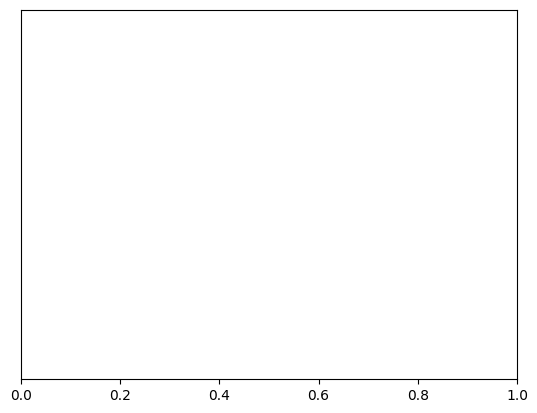

In [81]:
# Initial Setup:
# Import all the libraries we need

import matplotlib.pyplot as plt
plt.tick_params(left=False, labelleft=False) #remove ticks

import numpy as np
import csv
import math
import random
from BSE import Trader_PRZI
from BSE import market_session
import pandas as pd
from scipy import stats
import pylab 
import scipy.stats as stats

# reload imports
%reload_ext autoreload
%autoreload 2

# The next are helper functions that you will use later, if they don't make 
# much sense now, don't worry too much about it they will become clearer later:

# Use this to plot trades of a single experiment
def plot_trades(trial_id):
    prices_fname = trial_id + '_tape.csv'
    x = np.empty(0)
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            time = float(row[1])
            price = float(row[2])
            x = np.append(x,time)
            y = np.append(y,price)

    plt.plot(x, y, 'x', color='black') 
    
# Use this to run an experiment n times and plot all trades
def n_runs_plot_trades(n, trial_id, start_time, end_time, traders_spec, order_sched):
    x = np.empty(0)
    y = np.empty(0)

    for i in range(n):
        trialId = trial_id + '_' + str(i)
        tdump = open(trialId + '_avg_balance.csv','w')

        market_session(trialId, start_time, end_time, traders_spec, order_sched, tdump, True, False)
        
        tdump.close()

        with open(trialId + '_tape.csv', newline='') as csvfile:
            reader = csv.reader(csvfile)
            for row in reader:
                time = float(row[1])
                price = float(row[2])
                x = np.append(x,time)
                y = np.append(y,price)

    plt.plot(x, y, 'x', color='black');

# !!! Don't use on it's own   
def getorderprice(i, sched, n, mode):
    pmin = min(sched[0][0], sched[0][1])
    pmax = max(sched[0][0], sched[0][1])
    prange = pmax - pmin
    stepsize = prange / (n - 1)
    halfstep = round(stepsize / 2.0)

    if mode == 'fixed':
        orderprice = pmin + int(i * stepsize)
    elif mode == 'jittered':
        orderprice = pmin + int(i * stepsize) + random.randint(-halfstep, halfstep)
    elif mode == 'random':
        if len(sched) > 1:
            # more than one schedule: choose one equiprobably
            s = random.randint(0, len(sched) - 1)
            pmin = min(sched[s][0], sched[s][1])
            pmax = max(sched[s][0], sched[s][1])
        orderprice = random.randint(pmin, pmax)
    return orderprice    

# !!! Don't use on it's own
def make_supply_demand_plot(bids, asks):
    # total volume up to current order
    volS = 0
    volB = 0

    fig, ax = plt.subplots()
    plt.ylabel('Price')
    plt.xlabel('Quantity')
    
    pr = 0
    for b in bids:
        if pr != 0:
            # vertical line
            ax.plot([volB,volB], [pr,b], 'r-')
        # horizontal lines
        line, = ax.plot([volB,volB+1], [b,b], 'r-')
        volB += 1
        pr = b
    if bids:
        line.set_label('Demand')
        
    pr = 0
    for s in asks:
        if pr != 0:
            # vertical line
            ax.plot([volS,volS], [pr,s], 'b-')
        # horizontal lines
        line, = ax.plot([volS,volS+1], [s,s], 'b-')
        volS += 1
        pr = s
    if asks:
        line.set_label('Supply')
        
    if bids or asks:
        plt.legend()
    plt.show()

# Use this to plot supply and demand curves from supply and demand ranges and stepmode
def plot_sup_dem(seller_num, sup_ranges, buyer_num, dem_ranges, stepmode):
    asks = []
    for s in range(seller_num):
        asks.append(getorderprice(s, sup_ranges, seller_num, stepmode))
    asks.sort()
    bids = []
    for b in range(buyer_num):
        bids.append(getorderprice(b, dem_ranges, buyer_num, stepmode))
    bids.sort()
    bids.reverse()
    
    make_supply_demand_plot(bids, asks) 

# plot sorted trades, useful is some situations - won't be used in this worksheet
def in_order_plot(trial_id):
    prices_fname = trial_id + '_tape.csv'
    y = np.empty(0)
    with open(prices_fname, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            price = float(row[2])
            y = np.append(y,price)
    y = np.sort(y)
    x = list(range(len(y)))

    plt.plot(x, y, 'x', color='black')   

# plot offset function
def plot_offset_fn(offset_fn, total_time_seconds):   
    x = list(range(total_time_seconds))
    offsets = []
    for i in range(total_time_seconds):
        offsets.append(offset_fn(i))
    plt.plot(x, offsets, 'x', color='black')  

## Set up for static market session

In [7]:
n_days = 3                 #10 days for f=0.8
n_hours = 24*n_days
start_time = 0.0
end_time = 60*60*n_hours
duration = end_time - start_time

supRange = (60, 140)
demRange = (60, 140)
supply_schedule = [{'from': start_time, 'to': end_time, 'ranges': [supRange], 'stepmode': 'fixed'}]
demand_schedule = [{'from': start_time, 'to': end_time, 'ranges': [demRange], 'stepmode': 'fixed'}]

order_interval = 5
order_sched = {'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}


# 4 - 11
k_min = 4
k_max = 12

## Experiment 1: Changing the values of k

### Market session - Keeping F = 0.8 and finding best k value

In [20]:
trail_id = 'change_k_outputs/change_K'

# fname = trail_id + '_balances.csv'
# tdump = open(fname, 'w')

# for k in range(k_min,k_max):
#     buyers_spec = [('PRDE', 30, {'k': k, 'f_value':0.8, 's_min': -1.0, 's_max': +1.0})] 
#     sellers_spec = buyers_spec
#     traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#     trial = 1
#     while trial <= 1:
#         trial_id = trail_id+'_%d' % (k)
#         market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)
#         tdump.flush()
#         trial+=1
    
# tdump.close()    


### Create a plot_csv function to read the pps values from all the strats.csv files (and plot them)

In [56]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#24B99F'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
CB91_Brown= '#98501C'
CB91_Red = '#D43334'

def plot_csv(filename, k_value, f_value):
    df = pd.read_csv( filename,header=None,)
    new_df_buyer = pd.DataFrame()
    new_df_seller = pd.DataFrame()
    
    for row in range(0,len(df.index)):
        b_sum = 0
        s_sum = 0
        for col in range (8, 219 ,7):
            b_sum +=df.loc[row][col]
        new_df_buyer.loc[len(new_df_buyer.index), 0] = b_sum

        for col in range (225, 428,7):
            s_sum +=df.loc[row][col]
        new_df_seller.loc[len(new_df_seller.index), 0] = s_sum
      
    buyers_sma = new_df_buyer.loc[:,0].rolling(5).mean()
    sellers_sma = new_df_seller.loc[:,0].rolling(5).mean()
    total_sma =  buyers_sma + sellers_sma
    
    # Comment out if running compare_pps_different_k() ---------------------------------
#     t_period = list(range(0,len(buyers_sma.index)))
#     plt.plot(t_period, buyers_sma, color=CB91_Green, label='Sum Profit') 
#     plt.plot(t_period, sellers_sma, color=CB91_Blue, label='Buyers Profit') 
#     plt.plot(t_period, total_sma, color=CB91_Pink, label='Sellers Profit') 
#     plt.xlabel("Hours")
#     plt.ylabel("Profit Per Second")
#     plt.title(f"Profit: PRDE with F={f_value} and K={k_value}")
#     plt.legend(frameon=False)
#     plt.grid(linewidth=0.4)
    
#     # save figures
#     figure_filename = (f'figures/change_k/Change_K%02d_F{f_value}.png' % (k_value))
#     plt.savefig(figure_filename)
#     plt.show()

    # -------------------------------------------------------------------------------
    return total_sma.fillna(0).to_numpy()
    

# for k in range(k_min, k_max):
#     plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
    

### Process the results to see if changing k is statistically significant

.
.
.
.
.
.
.
.


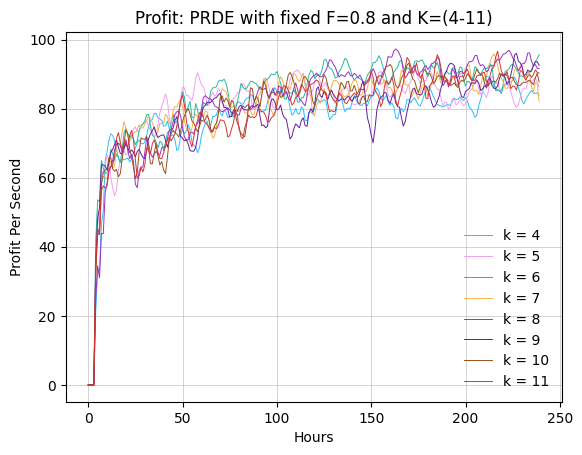

In [91]:
plt.xlabel("Hours")
plt.ylabel("Profit Per Second")
plt.title("Profit: PRDE with fixed F=0.8 and K=(4-11)")

def compare_pps_different_k(hours):
    colors = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber, CB91_Purple, CB91_Violet, CB91_Brown, CB91_Red]
    
    all_k_t_mov_avg = []
    i=0
    for k in range(k_min, k_max):
        k_t_mov_avg = plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
        all_k_t_mov_avg.append(k_t_mov_avg)
        
        t_period = list(range(0,hours))
        plt.plot(t_period, k_t_mov_avg, color=colors[i],linewidth = '0.7', label=f'k = {k}') 
        print(".")
        i+=1
    
    plt.legend(frameon=False)
    plt.grid(linewidth=0.4)
    # plt.savefig(f'figures/change_k/Change_K_F0.8_TOTAL.png')
    plt.show()
    return(all_k_t_mov_avg)

all_k_sma = compare_pps_different_k(10*24)


.
.
.
.
.
.
.
.


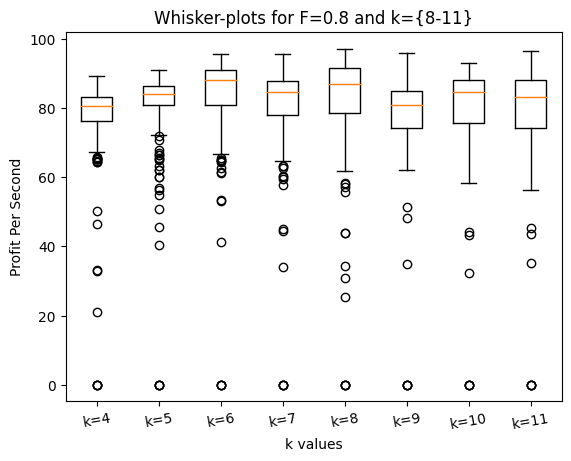

In [90]:
# Plot whisker plots

def get_all_avg_change_k():
    all_k_t_mov_avg = []
    i=0
    for k in range(k_min, k_max):
        k_t_mov_avg = plot_csv(trail_id + '_' + str(k) + '_strats.csv', k, 0.8)
        all_k_t_mov_avg.append(k_t_mov_avg)
        print(".")
        i+=1
    return all_k_t_mov_avg

all_k_t_mov_avg = get_all_avg_change_k()

fig1, ax1 = plt.subplots()
ax1.set_title('Whisker-plots for F=0.8 and k={8-11}')

ax1.boxplot(all_k_t_mov_avg)

locs = [1,2,3,4,5,6,7,8]
labels = ['k=4', 'k=5', 'k=6', 'k=7', 'k=8', 'k=9', 'k=10', 'k=11']
plt.xticks(locs,labels, rotation=10)
plt.xlabel("k values")
plt.ylabel("Profit Per Second")
# plt.savefig(f'figures/change_k/whisker_plot.png')

plt.show()

# no specific k values median is way above the others. so its either no difference or we need to do a better test!
# data is not normally distributed => check!

In [105]:
# Check if data is normally distributed
# (Visual Method) Create a Q-Q plot.
# (Formal Statistical Test) Perform a Shapiro-Wilk Test: if pvalue > 0.05 then data is normally distribution

for i, k in enumerate(all_k_t_mov_avg):
    shapiro_test = stats.shapiro(k)
    print(f"k={i+4}:   {shapiro_test}")
    # stats.probplot(k, dist="norm", plot=pylab)
    ## pylab.savefig(f'figures/change_k/distribution_test/k_{i+4}.png')
    # pylab.show()  
    # print("\n")


# conclusion -> data is not normally distributed, so need to do a non-parametric test

k=4:   ShapiroResult(statistic=0.5557814836502075, pvalue=2.551508080710624e-24)
k=5:   ShapiroResult(statistic=0.545596718788147, pvalue=1.4891225742015493e-24)
k=6:   ShapiroResult(statistic=0.6151193380355835, pvalue=7.218626961051016e-23)
k=7:   ShapiroResult(statistic=0.6037665605545044, pvalue=3.698203273958898e-23)
k=8:   ShapiroResult(statistic=0.7105494737625122, pvalue=3.9986834926653944e-20)
k=9:   ShapiroResult(statistic=0.6778428554534912, pvalue=3.919759314676612e-21)
k=10:   ShapiroResult(statistic=0.6598526835441589, pvalue=1.1779459858506422e-21)
k=11:   ShapiroResult(statistic=0.7124366164207458, pvalue=4.599250867826131e-20)


.

### Non-parametric: Kruskal Wallis test

In [95]:

# we have k={4-11} 8 'samples' i.e. sets of sma's
# we want to test to see if they come from the same population sample?

# want to not assume anything about the distribution of the sample -> non-parametric
# mannwhitney doesnt do well for multiple pairwise tests
# nul hypothesis h0: data from 2 samples comes from the same populations
# if calcualted u value less than critical value (from table) for the same u combination,
# usually like 0.01 or 0.05, then reject h0 (so the samples do not come from the same populations)

# kruskal wallis test
# allows multiple group comparions. Generalised u-test for multiple groups

stats.kruskal(all_k_sma[0],all_k_sma[1],all_k_sma[2],all_k_sma[3],all_k_sma[4],all_k_sma[5],all_k_sma[6],all_k_sma[7])

# pvalue > 0.05 so reject null hypo, conclude samples do not come from same population 
# so changing k leads to statistically significant differences in profits ????


KruskalResult(statistic=160.15627697365926, pvalue=2.9738147379757086e-31)

.

## Experiment 1: Changing the values of F

### Pick arbitrary k values for the next experiment cause doing all would take too long

In [102]:
print("BASED ON MEAN ==========================================================================================================================")

all_means = []
for i in range(len(all_k_t_mov_avg)):
    mean_i = np.mean(all_k_t_mov_avg[i])
    all_means.append(mean_i)

# Best k for f=0.8
maxMean = max(all_means)
maxK = np.argmax(all_means) + 4

print(f"Best_k overall for f=0.8: {maxK}")
print(f"Mean: {maxMean}")

# Top 4 performning k's for f=0.8
top3_means_and_k = sorted(((value, index) for index, value in enumerate(all_means)), reverse=True)[:3]
top3_k = []
for n in top3_means_and_k:
    top3_k.append(n[1]+4)

print("\nTop 3 performing k values for f=0.8:", top3_k)


print("\nBASED ON MEDIAN ==========================================================================================================================")
all_medians = []
for i in range(len(all_k_t_mov_avg)):
    mean_i = np.median(all_k_t_mov_avg[i])
    all_medians.append(mean_i)

maxMedian = max(all_medians)
maxk = np.argmax(all_medians) + 4

print(f"Best_k overall for f=0.8: {maxK}")
print(f"Median: {maxMedian}")

# Top 4 performning k's for f=0.8 --------
top3_medians_and_k = sorted(((value, index) for index, value in enumerate(all_medians)), reverse=True)[:3]
top3_k_medians = []
for n in top3_medians_and_k:
    top3_k_medians.append(n[1]+4)

print("\nTop 3 performing k values for f=0.8:", top3_k_medians)

BASED ON MEAN ==========================================================================================================================
Best_k overall for f=0.8: 6
Mean: 83.52948044583333

Top 3 performing k values for f=0.8: [6, 8, 7]

BASED ON MEDIAN ==========================================================================================================================
Best_k overall for f=0.8: 6
Median: 88.0890661

Top 3 performing k values for f=0.8: [6, 8, 10]


### Market session - Change f=(0-2) for top 3 k values (TODO run for k=10)

In [107]:
trail_id = 'change_f_for_top3_k_outputs/change'

# fname = trail_id + '_F_top3_K_balances.csv'
# tdump = open(fname, 'w')

# for f in np.arange(0.0,2.0,0.1):
#     for k in top3_k:      # k = 6,8,7
#         buyers_spec = [('PRDE', 30, {'k': k, 'f_value':f, 's_min': -1.0, 's_max': +1.0})] 
#         sellers_spec = buyers_spec
#         traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#         trial = 1
#         while trial <= 1:
#             trial_id = trail_id+f'_K%02d_F{f}' % (k)
#             market_session(trial_id, start_time, end_time, traders_spec,order_sched, tdump, False, True)
#             tdump.flush()
#             trial+=1
    
# tdump.close()    


### Use plot_csv function to read the pps values from all the strats.csv files 

In [ ]:
total_F_k6_sma_array = []
total_F_k8_sma_array = []
total_F_k7_sma_array = []

for F in range(0, 2):
    F_k_sma_array = plot_csv(trail_id + '_K' + str(k) + '_F'+str(F)+'_strats.csv', 6, F)
    total_F_k6_sma_array.append(F_k_sma_array)
    

for F in range(0, 2):
    F_k_sma_array = plot_csv(trail_id + '_K' + str(k) + '_F'+str(F)+'_strats.csv', 8, F)
    total_F_k6_sma_array.append(F_k_sma_array)
    
for F in range(0, 2):
    F_k_sma_array = plot_csv(trail_id + '_K' + str(k) + '_F'+str(F)+'_strats.csv', 7, F)
    total_F_k6_sma_array.append(F_k_sma_array)

## Pick top 2(?) best (k,F) combo and perform one-in-many test and balanced group test

In [ ]:

# trail_id = 'trail'
# fname = trail_id + 'balances.csv'

# tdump = open(fname, 'w')

# min_n = 1

# # trialnumber = 1
# # trdr_1_n = min_n
# for k in range(4,13):
#     for f in np.arange(0.0,2.0,0.1):
#         buyers_spec = [('PRDE', 30, {'k': k, 'f_value':f, 's_min': -1.0, 's_max': +1.0})] 
#         sellers_spec = buyers_spec
#         traders_spec = {'sellers': sellers_spec, 'buyers': buyers_spec}

#         trial = 1
#         while trial <= 1:
#             trial_id = '%02d_%02f' % (k, f)
#             market_session(trial_id, start_time, end_time, traders_spec,
#                            order_sched, tdump, False, True)
#             tdump.flush()
#             trial+=1

# tdump.close()

.

## Experiment 2: Changing the values of k and F hetrogenously

## Experiment 3: Dynamic Market